# 05A — Macro Factor Exposure

**Purpose**: What macro factors you are implicitly betting on

**Outputs**:
- Equity beta (to domestic and global)
- Rate duration sensitivity
- FX sensitivity
- Commodity exposure

---

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

PROCESSED_PATH = Path('../data_processed')

# Load data
combined = pd.read_parquet(PROCESSED_PATH / 'macro_sector_monthly_matrix.parquet')

print(f"Data loaded: {combined.shape}")

Data loaded: (132, 93)


## 1. Define Factor Universe

In [2]:
# Factor definitions
FACTOR_DEFINITIONS = {
    'EQUITY_BETA': {
        'description': 'Sensitivity to global equity markets',
        'proxies': ['GLOBAL_SP500', 'GLOBAL_MSCI_EM'],
        'interpretation': 'Higher = more risk-on exposure'
    },
    'RATE_DURATION': {
        'description': 'Sensitivity to interest rate changes',
        'proxies': ['GLOBAL_US10Y', 'GLOBAL_US10Y_Delta'],
        'interpretation': 'Negative = hurt by rising rates'
    },
    'FX_SENSITIVITY': {
        'description': 'Sensitivity to INR moves',
        'proxies': ['GLOBAL_DXY', 'USDINR'],
        'interpretation': 'Positive = benefit from weak INR'
    },
    'COMMODITY_EXPOSURE': {
        'description': 'Sensitivity to commodity prices',
        'proxies': ['GLOBAL_BRENT', 'GLOBAL_COPPER'],
        'interpretation': 'Negative = hurt by rising inputs'
    }
}

print(f"Defined {len(FACTOR_DEFINITIONS)} macro factors")

Defined 4 macro factors


## 2. Prepare Sector Returns and Factor Proxies

In [3]:
# Get sector returns
index_cols = [c for c in combined.columns if c.startswith('IDX_')]
sector_returns = combined[index_cols].copy()
sector_returns.columns = [c.replace('IDX_', '').replace('NIFTY_', '') for c in sector_returns.columns]

# Get global/macro columns for factors
global_cols = [c for c in combined.columns if c.startswith('GLOBAL_')]
macro_cols = [c for c in combined.columns if c.startswith('MACRO_')]

print(f"Sectors: {len(sector_returns.columns)}")
print(f"Global factors: {len(global_cols)}")
print(f"Macro factors: {len(macro_cols)}")

Sectors: 21
Global factors: 8
Macro factors: 64


## 3. Calculate Factor Betas

In [4]:
def calculate_factor_beta(sector_returns: pd.Series, factor_returns: pd.Series,
                          min_obs: int = 30) -> dict:
    """
    Calculate beta (regression coefficient) of sector to factor.
    """
    # Align data
    valid = pd.concat([sector_returns, factor_returns], axis=1).dropna()
    
    if len(valid) < min_obs:
        return {'beta': np.nan, 'r_squared': np.nan, 't_stat': np.nan}
    
    y = valid.iloc[:, 0]
    x = valid.iloc[:, 1]
    
    # Simple linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    t_stat = slope / std_err if std_err > 0 else 0
    
    return {
        'beta': slope,
        'r_squared': r_value ** 2,
        't_stat': t_stat,
        'p_value': p_value
    }

print("Beta calculation function defined")

Beta calculation function defined


In [5]:
# Calculate betas for available factors
beta_results = []

# Find available factor proxies
available_factors = [c for c in combined.columns if c.startswith('GLOBAL_') or c.startswith('MACRO_')]

# Select key factors
key_factors = [f for f in available_factors if any(
    keyword in f for keyword in ['US10Y', 'SP500', 'DXY', 'BRENT', 'GOLD']
)]

if not key_factors and len(available_factors) > 0:
    key_factors = available_factors[:5]  # Take first 5 if no matches

print(f"Key factors for beta analysis: {key_factors}")

for sector in sector_returns.columns:
    for factor in key_factors:
        if factor in combined.columns:
            result = calculate_factor_beta(
                sector_returns[sector],
                combined[factor]
            )
            result['sector'] = sector
            result['factor'] = factor.replace('GLOBAL_', '').replace('MACRO_', '')
            beta_results.append(result)

beta_df = pd.DataFrame(beta_results)
print(f"\nCalculated {len(beta_df)} sector-factor betas")

Key factors for beta analysis: ['GLOBAL_US10Y', 'GLOBAL_US10Y_Delta']



Calculated 42 sector-factor betas


## 4. Factor Exposure Heatmap

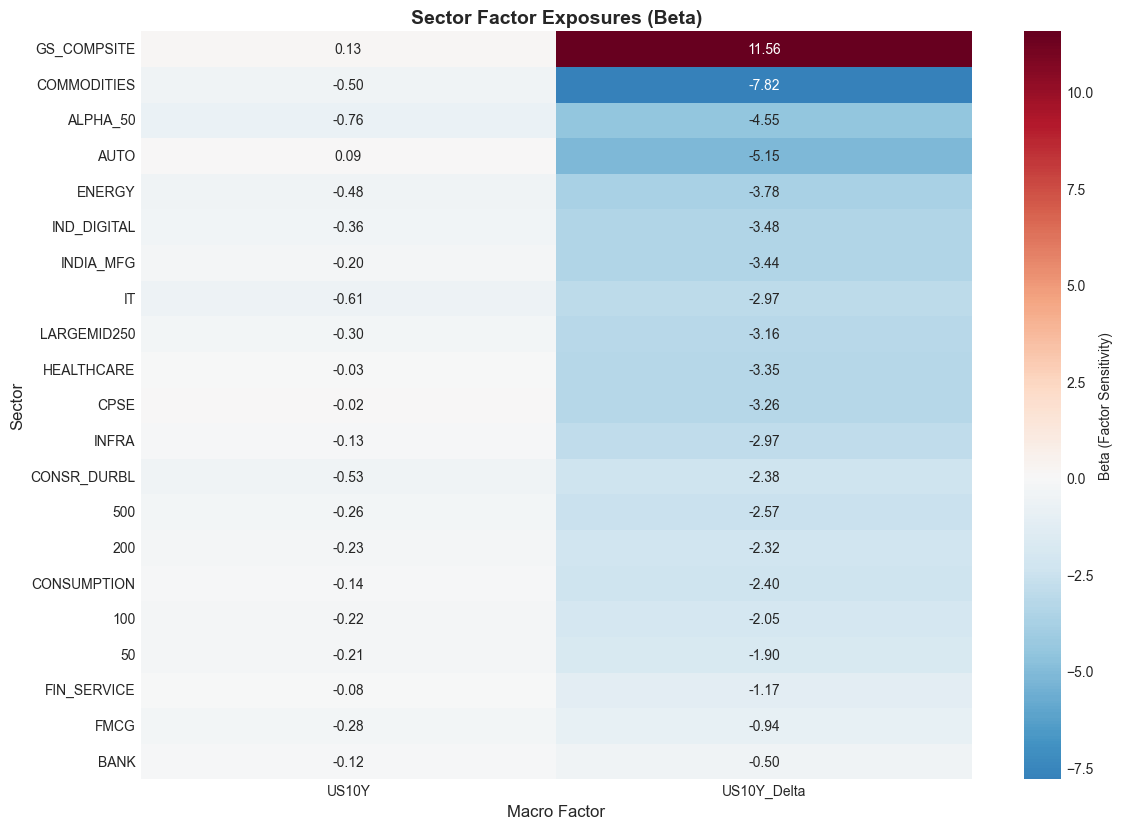

✓ Saved: factor_exposure_heatmap.png


In [6]:
if len(beta_df) > 0:
    # Pivot for heatmap
    beta_pivot = beta_df.pivot(index='sector', columns='factor', values='beta')
    
    # Sort by average absolute beta
    beta_pivot['avg_abs'] = beta_pivot.abs().mean(axis=1)
    beta_pivot = beta_pivot.sort_values('avg_abs', ascending=False).drop('avg_abs', axis=1)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, max(8, len(beta_pivot) * 0.4)))
    
    sns.heatmap(
        beta_pivot,
        cmap='RdBu_r',
        center=0,
        annot=True,
        fmt='.2f',
        ax=ax,
        cbar_kws={'label': 'Beta (Factor Sensitivity)'}
    )
    
    ax.set_title('Sector Factor Exposures (Beta)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Macro Factor', fontsize=12)
    ax.set_ylabel('Sector', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'factor_exposure_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: factor_exposure_heatmap.png")
else:
    print("No beta data available for heatmap")

## 5. Sector Factor Profiles

In [7]:
if len(beta_df) > 0:
    # Profile each sector
    print("\n📊 SECTOR FACTOR PROFILES")
    print("="*50)
    
    for sector in beta_pivot.index[:10]:  # Top 10 sectors
        sector_betas = beta_pivot.loc[sector].dropna()
        
        # Find strongest exposures
        top_positive = sector_betas[sector_betas > 0.1].nlargest(2)
        top_negative = sector_betas[sector_betas < -0.1].nsmallest(2)
        
        print(f"\n{sector}:")
        if len(top_positive) > 0:
            print(f"  ⬆️ Benefits from: {', '.join([f'{k} (β={v:.2f})' for k,v in top_positive.items()])}")
        if len(top_negative) > 0:
            print(f"  ⬇️ Hurt by: {', '.join([f'{k} (β={v:.2f})' for k,v in top_negative.items()])}")


📊 SECTOR FACTOR PROFILES

GS_COMPSITE:
  ⬆️ Benefits from: US10Y_Delta (β=11.56), US10Y (β=0.13)

COMMODITIES:
  ⬇️ Hurt by: US10Y_Delta (β=-7.82), US10Y (β=-0.50)

ALPHA_50:
  ⬇️ Hurt by: US10Y_Delta (β=-4.55), US10Y (β=-0.76)

AUTO:
  ⬇️ Hurt by: US10Y_Delta (β=-5.15)

ENERGY:
  ⬇️ Hurt by: US10Y_Delta (β=-3.78), US10Y (β=-0.48)

IND_DIGITAL:
  ⬇️ Hurt by: US10Y_Delta (β=-3.48), US10Y (β=-0.36)

INDIA_MFG:
  ⬇️ Hurt by: US10Y_Delta (β=-3.44), US10Y (β=-0.20)

IT:
  ⬇️ Hurt by: US10Y_Delta (β=-2.97), US10Y (β=-0.61)

LARGEMID250:
  ⬇️ Hurt by: US10Y_Delta (β=-3.16), US10Y (β=-0.30)

HEALTHCARE:
  ⬇️ Hurt by: US10Y_Delta (β=-3.35)


## 6. Portfolio Factor Exposure (Example)

In [8]:
# Example portfolio weights
EXAMPLE_PORTFOLIO = {
    'BANK': 0.20,
    'IT': 0.15,
    'AUTO': 0.10,
    'FMCG': 0.10,
    'PHARMA': 0.10,
    'INFRA': 0.10,
    'COMMODITIES': 0.05,
    'ENERGY': 0.05,
    'FIN_SERVICE': 0.10,
    'HEALTHCARE': 0.05
}

if len(beta_df) > 0:
    # Calculate weighted factor exposure
    portfolio_exposure = {}
    
    for factor in beta_pivot.columns:
        weighted_beta = 0
        for sector, weight in EXAMPLE_PORTFOLIO.items():
            if sector in beta_pivot.index:
                sector_beta = beta_pivot.loc[sector, factor]
                if pd.notna(sector_beta):
                    weighted_beta += weight * sector_beta
        portfolio_exposure[factor] = weighted_beta
    
    # Display
    print("\n📈 EXAMPLE PORTFOLIO FACTOR EXPOSURE")
    print("="*50)
    for factor, exposure in sorted(portfolio_exposure.items(), key=lambda x: abs(x[1]), reverse=True):
        direction = '⬆️' if exposure > 0 else '⬇️' if exposure < 0 else '➡️'
        print(f"  {direction} {factor}: β = {exposure:.3f}")


📈 EXAMPLE PORTFOLIO FACTOR EXPOSURE
  ⬇️ US10Y_Delta: β = -2.318
  ⬇️ US10Y: β = -0.207


## 7. Export Factor Exposures

In [9]:
if len(beta_df) > 0:
    # Save beta results
    beta_df.to_parquet(PROCESSED_PATH / 'sector_factor_betas.parquet', index=False)
    print("✓ Saved: sector_factor_betas.parquet")
    
    # Save pivot for easy viewing
    beta_pivot.to_parquet(PROCESSED_PATH / 'factor_exposure_matrix.parquet')
    beta_pivot.to_csv(PROCESSED_PATH / 'factor_exposure_matrix.csv')
    print("✓ Saved: factor_exposure_matrix.parquet/csv")

✓ Saved: sector_factor_betas.parquet
✓ Saved: factor_exposure_matrix.parquet/csv


## 8. Key Outputs ✓

### Factor Exposure Summary

| Factor | What It Measures | Portfolio Implication |
|--------|-----------------|----------------------|
| Equity Beta | Global risk appetite | Reduce in risk-off |
| Rate Duration | Interest rate sensitivity | Monitor vs US 10Y |
| FX Sensitivity | INR exposure | Hedge if short INR |
| Commodity Exposure | Input cost sensitivity | Watch oil, copper |

### Outputs
- `sector_factor_betas.parquet` — Full beta calculations
- `factor_exposure_matrix.parquet` — Sector × Factor matrix
- `factor_exposure_heatmap.png` — Visualization

**Next notebook:** `05B_scenario_stress_testing.ipynb`